In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
# import mticker
import matplotlib.ticker as mticker

In [2]:
# Import Macro Variables data
macro = pd.ExcelFile('Macro Variables.xlsx')
macro_yearly = pd.read_excel(macro, 'Macro Variables')
macro_monthly = pd.read_excel(macro, 'Macro Variables monthly')

TypeError: 'ExcelFile' object is not subscriptable

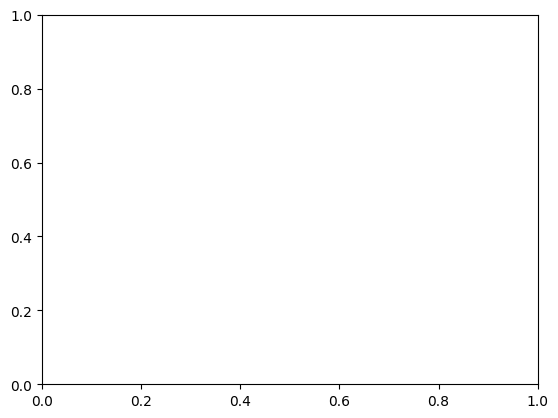

In [3]:
fig, ax = plt.subplots()
ax.plot(macro['Time'], macro['WHP'], label='WPI')
ax.set_ylabel('Wholesale Price Index')
ax.grid(color='#cccccc')
ax.legend()

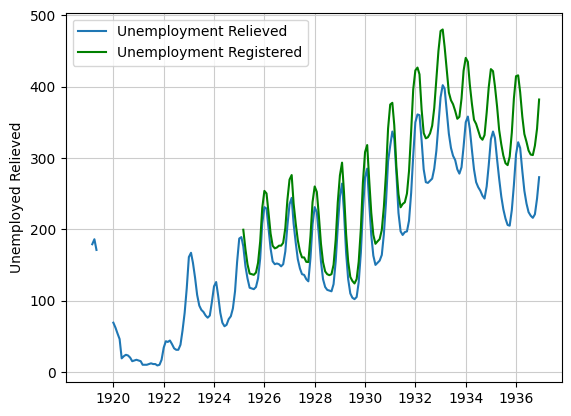

In [5]:
fig, ax = plt.subplots()
ax.plot(macro_monthly['Date'], macro_monthly['Unemployed Relieved'], label='Unemployment Relieved')
ax.plot(macro_monthly['Date'], macro_monthly['Unemployed Registered'], label='Unemployment Registered', color='green')
ax.set_ylabel('Unemployed Relieved')
ax.grid(color='#cccccc')
ax.legend()


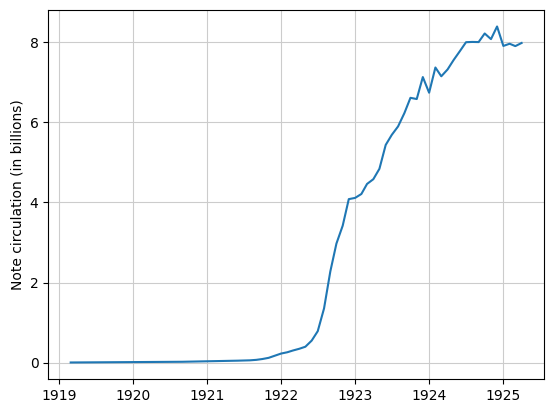

In [6]:
fig, ax = plt.subplots()
ax.plot(macro_monthly['Date'], macro_monthly['Note circulation']/ 1e9, label='Note circulation')
ax.set_ylabel('Note circulation (in billions)')
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())
ax.ticklabel_format(style='plain', axis='y')
ax.grid(color='#cccccc')

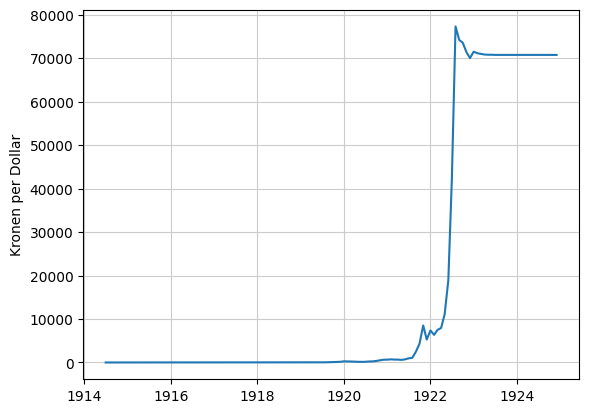

In [7]:
# exchange rate
fig, ax = plt.subplots()
ax.plot(macro_monthly['Date'], macro_monthly['Exchange Rate'], label='Kronen per Dollar')
ax.set_ylabel('Kronen per Dollar')
ax.grid(color='#cccccc')


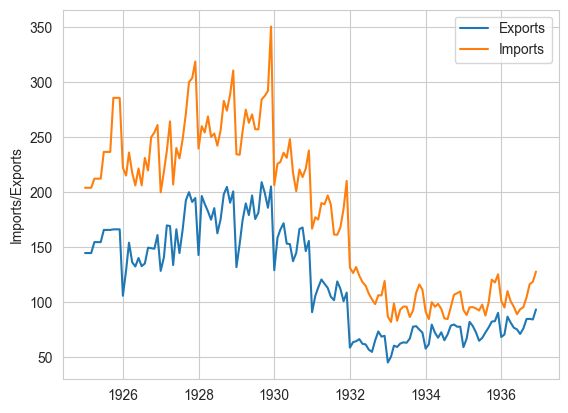

In [75]:
fig, ax = plt.subplots()
ax.plot(macro['Time'], macro['TOTEX'], label='Exports')
ax.plot(macro['Time'], macro['TOTIM'], label='Imports')
ax.set_ylabel('Imports/Exports')
ax.grid(color='#cccccc')
ax.legend()

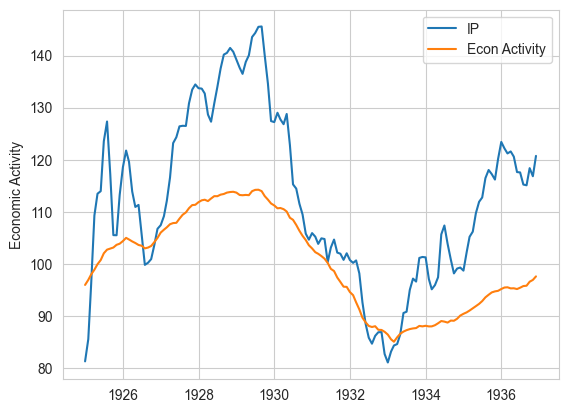

In [77]:
fig, ax = plt.subplots()
ax.plot(macro['Time'], macro['IP'], label='IP')
ax.plot(macro['Time'], macro['EconActivity_GDP'], label='Econ Activity')
ax.set_ylabel('Economic Activity')
ax.grid(color='#cccccc')
ax.legend()

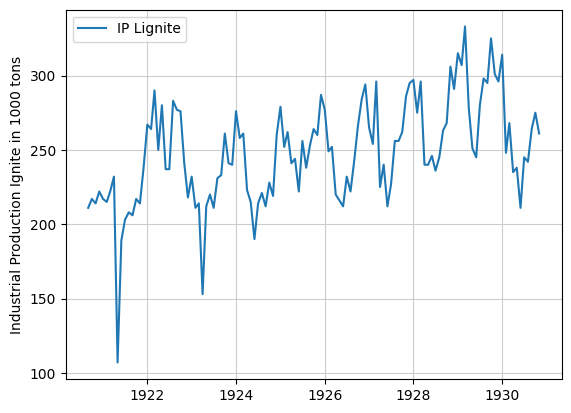

In [10]:
# Alternative IP measure but earlier
fig, ax = plt.subplots()
ax.plot(macro_monthly['Date'], macro_monthly['Ip Lignite'], label='IP Lignite')
ax.set_ylabel('Industrial Production Ignite in 1000 tons')
ax.grid(color='#cccccc')
ax.legend()

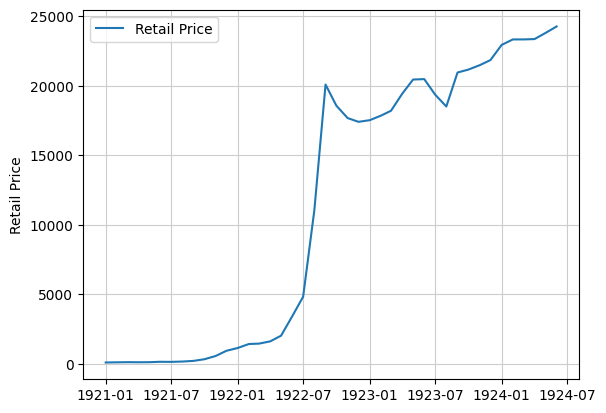

In [5]:
# Alternative IP measure but earlier
fig, ax = plt.subplots()
ax.plot(macro_monthly['Date'], macro_monthly['Retail Young'], label='Retail Price')
ax.set_ylabel('Retail Price')
ax.grid(color='#cccccc')
ax.legend()

YEARLY DATA

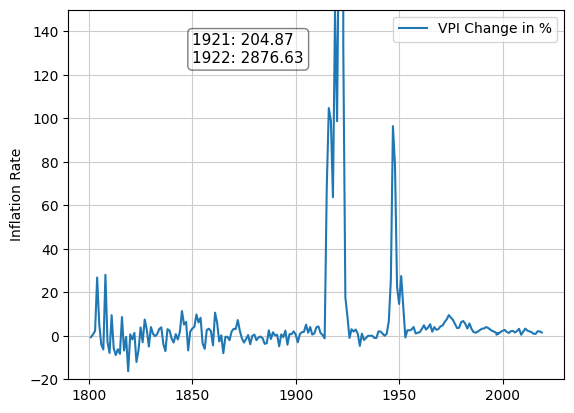

In [79]:
fig, ax = plt.subplots()
ax.plot(yearly['Time'], yearly['VPI Change'], label='VPI Change in %')
# y axis limited to 0-100
ax.set_ylim(-20, 150)
ax.set_ylabel('Inflation Rate')
ax.grid(color='#cccccc')
textstr = '\n'.join((
    r'1921: 204.87',
    r'1922: 2876.63'
))

props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.25, 0.9, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='center_baseline', bbox=props)
ax.legend()

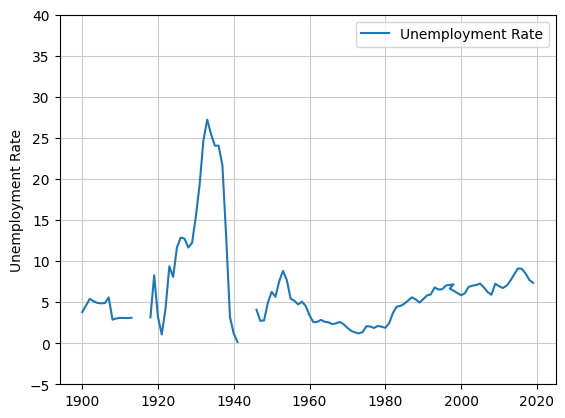

In [62]:
fig, ax = plt.subplots()
ax.plot(yearly['Time'], yearly['Unemployment Quota'], label='Unemployment Rate')
# y axis limited to 0-100
ax.set_ylim(-5, 40)
ax.set_ylabel('Unemployment Rate')
ax.grid(color='#cccccc')
ax.legend()

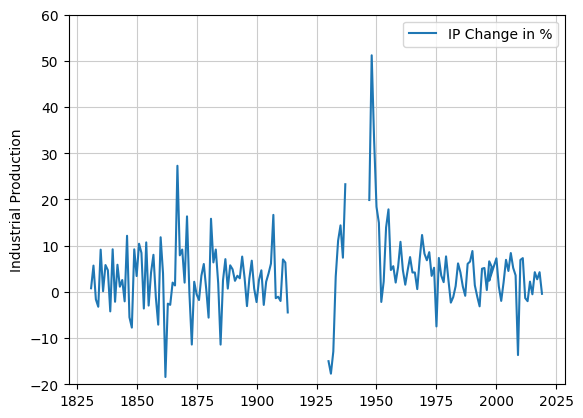

In [64]:
fig, ax = plt.subplots()
ax.plot(yearly['Time'], yearly['IP Change'], label='IP Change in %')
# y axis limited to 0-100
ax.set_ylim(-20, 60)
ax.set_ylabel('Industrial Production')
ax.grid(color='#cccccc')
ax.legend()

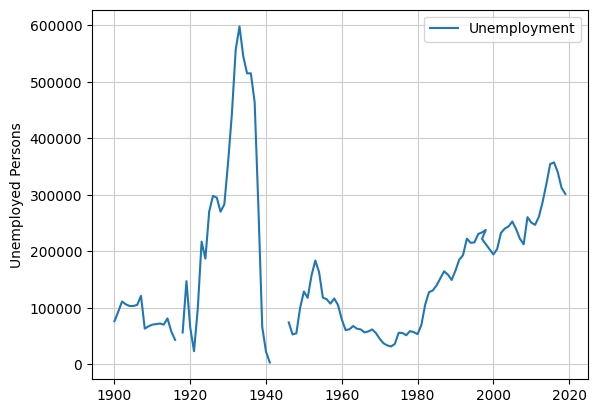

In [83]:
fig, ax = plt.subplots()
ax.plot(yearly['Time'], yearly['Unemployed'], label='Unemployment')
ax.set_ylabel('Unemployed Persons')
ax.grid(color='#cccccc')
ax.legend()

EPU and VAR

In [3]:
# From macro_monthly only keep Retail Young, Ip Lignite, Exchange Rate, and Note circulation
macro_monthly = macro_monthly[['Date','EPU','Retail Young', 'Ip Lignite', 'Exchange Rate', 'Note circulation']]


In [4]:

# Only keep from 1921-01-01 to 1924-06-01
macro_monthly = macro_monthly[macro_monthly['Date'] >= '1921-01-01']
macro_monthly = macro_monthly[macro_monthly['Date'] <= '1924-06-01']

In [5]:

data = macro_monthly.copy()
# 2. Define a function to check for stationarity and determine the differencing order.
def get_diff_order(series, signif=0.05):
    series_clean = series.dropna()
    adf_result = adfuller(series_clean)
    p_value = adf_result[1]
    
    if p_value < signif:
        return 0
    else:
        # Test first difference
        series_diff = series_clean.diff().dropna()
        adf_result_diff = adfuller(series_diff)
        if adf_result_diff[1] < signif:
            return 1
        else:
            return 2

# %%
# 3. Check the integration order for each variable.
order_epu   = get_diff_order(data["EPU"])
order_retail = get_diff_order(data["Retail Young"])
order_ip   = get_diff_order(data["Ip Lignite"])
order_fx    = get_diff_order(data["Exchange Rate"])
order_note  = get_diff_order(data["Note circulation"])
print("Differencing orders:")
print("EPU:         ", order_epu)
print("Inflation:", order_retail)
print("IP:         ", order_ip)
print("FX:          ", order_fx)
print("Note:        ", order_note)


Differencing orders:
EPU:          1
Inflation: 1
IP:          0
FX:           1
Note:         2


In [6]:
# 4. Prepare and align the data by applying additional differencing if needed.
EPU_final   = data["EPU"].diff()
# Differentiate Retail Price once
Retail_final = data["Retail Young"].diff()
IP_final    = data["Ip Lignite"]
FX_final    = data["Exchange Rate"].diff()
Note_final  = data["Note circulation"].diff()
# Combine series into one DataFrame.
var_data = pd.DataFrame({
    "EPU":   EPU_final,
    "Inflation": Retail_final,
    "IP":    IP_final,
    "FX":     FX_final,
    "Note":   Note_final
})

# Drop rows with missing values (from differencing)
var_data = var_data.dropna()
print("\nNumber of observations after alignment:", len(var_data))

# Order columns so that EPU is first (for Cholesky identification).
var_data = var_data[["EPU", "Inflation", "Note", "FX", "IP"]]
print("\nColumns in VAR data:", var_data.columns.tolist())



Number of observations after alignment: 41

Columns in VAR data: ['EPU', 'Inflation', 'Note', 'FX', 'IP']


In [7]:

# 5. Select the optimal lag order for the VAR model.
# With limited data, we need to set a smaller maximum lag.
nobs = len(var_data)
k = var_data.shape[1]
max_possible_lags = nobs - k - 1  # degrees of freedom condition

if max_possible_lags < 1:
    raise ValueError("Not enough observations to estimate a VAR model.")

# Choose a maximum lag; here we set it to 2 if possible, otherwise use the maximum possible lags.
maxlags_used = min(2, max_possible_lags)
print(f"\nNumber of observations: {nobs}")
print(f"Maximum possible lags based on data: {max_possible_lags}")
print(f"Using maxlags = {maxlags_used} for lag order selection.\n")

model = VAR(var_data)
lag_order_results = model.select_order(maxlags=maxlags_used)
print("Lag Order Selection Criteria:")
print(lag_order_results.summary())

# Select lag order based on AIC (if available)
selected_lag = lag_order_results.aic
print("\nSelected lag order (AIC):", selected_lag)

# %%
# 6. Estimate the VAR model using the selected lag order.
var_results = model.fit(selected_lag)
print("\nVAR Model Summary:")
print(var_results.summary())




Number of observations: 41
Maximum possible lags based on data: 35
Using maxlags = 2 for lag order selection.

Lag Order Selection Criteria:
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       84.44       84.65   4.674e+36       84.51
1       82.71      83.99*   8.453e+35      83.17*
2      82.53*       84.88  7.556e+35*       83.38
-------------------------------------------------

Selected lag order (AIC): 2

VAR Model Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 11, Mar, 2025
Time:                     21:11:26
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                    84.8803
Nobs:                     39.0000    HQIC:                   83.3760
Log likelihood:          -1831.11    FPE:                7.55613e+35
AIC:    

c:\Users\vollm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


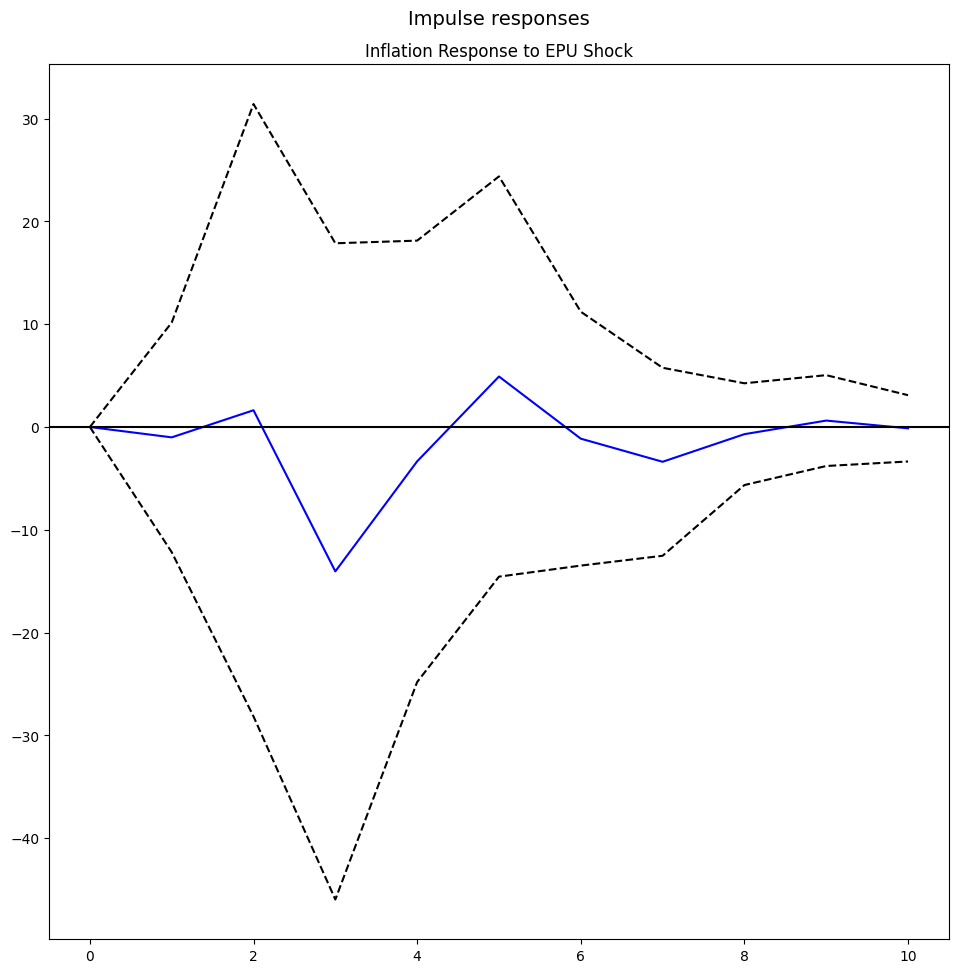

In [8]:
# 7. Compute and plot the Impulse Response Functions (IRFs)
# Compute IRFs for 10 periods ahead.
irf = var_results.irf(10)

# Plot IRFs for only for an EPU shock on the other variables, but not more shocks
irf.plot(impulse="EPU", response="Inflation")
plt.title("Inflation Response to EPU Shock")
plt.show()




SLP

In [9]:
df = macro_monthly.copy()
df = df.rename(columns={
    "Retail Young": "inflation",
    "Ip Lignite": "ip",
    "Exchange Rate": "fx",
    "Note circulation": "note"
})


In [10]:
def local_projection_irf_extended(
    data, 
    dep_var, 
    shock_var, 
    controls=None, 
    lags=2, 
    horizon=12
):
    if controls is None:
        controls = []

    betas = []
    ses = []
    pvals = []

    df = data.copy()
    
    for h in range(1, horizon + 1):
        # Future change: y_{t+h} - y_t
        df[f'{dep_var}_fwd_{h}'] = df[dep_var].shift(-h) - df[dep_var]
        
        # Build design matrix X
        # 1) current shock
        # 2) lags of dep_var
        # 3) lags of shock_var
        # 4) any extra controls

        # Start with an empty DataFrame for X
        X_cols = {}
        
        # Current shock at time t
        X_cols[f'{shock_var}_t'] = df[shock_var]
        
        # Lags of dependent variable
        for lag_i in range(1, lags+1):
            X_cols[f'{dep_var}_lag_{lag_i}'] = df[dep_var].shift(lag_i)
        
        # Lags of shock
        for lag_i in range(1, lags+1):
            X_cols[f'{shock_var}_lag_{lag_i}'] = df[shock_var].shift(lag_i)
        
        # Additional controls (levels or differences)
        for ctrl_var in controls:
            X_cols[ctrl_var] = df[ctrl_var]
        
        # Create the design matrix
        X_df = pd.DataFrame(X_cols)
        
        # Merge with the dependent variable forward difference
        full_df = pd.concat([df[f'{dep_var}_fwd_{h}'], X_df], axis=1).dropna()
        
        Y = full_df[f'{dep_var}_fwd_{h}']
        X = sm.add_constant(full_df.drop(columns=[f'{dep_var}_fwd_{h}']))
        
        # Fit OLS
        model = sm.OLS(Y, X).fit()
        
        # Save coefficient of the *current* shock
        # (If you want the total effect of shock_t plus lags, you might sum them.)
        coeff_name = f'{shock_var}_t'
        betas.append(model.params[coeff_name])
        ses.append(model.bse[coeff_name])
        pvals.append(model.pvalues[coeff_name])

    results_df = pd.DataFrame({
        'horizon': range(1, horizon + 1),
        'beta': betas,
        'se': ses,
        'pval': pvals
    })

    return results_df


    horizon        beta         se      pval
0         1    5.544275  14.714805  0.708988
1         2   36.872155  31.309285  0.248501
2         3   51.890791  43.634290  0.244340
3         4   85.389763  50.188442  0.100361
4         5   86.788829  55.933528  0.132836
5         6   57.668181  58.384984  0.332752
6         7   17.929771  67.822932  0.793758
7         8  -11.883783  68.655212  0.864092
8         9   28.863123  72.888846  0.695928
9        10   91.725878  75.540357  0.238126
10       11  136.500032  80.409939  0.105100
11       12   98.712134  79.286407  0.228267


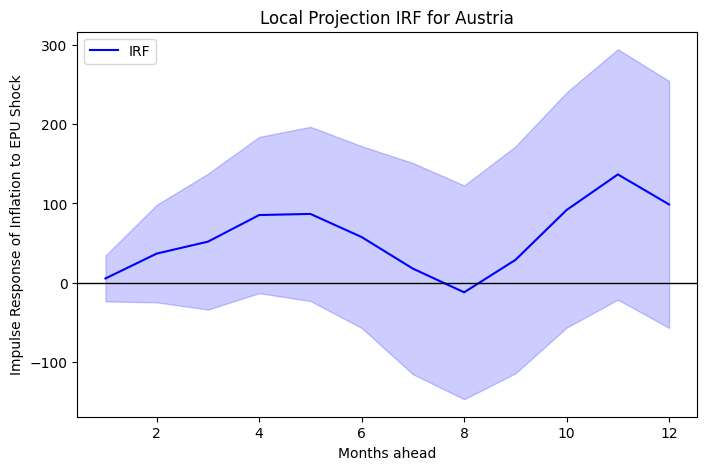

In [12]:
# Suppose we want to see how 'inflation' responds to an 'EPU' shock
# controlling for lags of both inflation and EPU, plus a control variable 'fx'.
results_inflation = local_projection_irf_extended(
    data=df, 
    dep_var='inflation', 
    shock_var='EPU', 
    controls=['ip', 'note', 'fx'], 
    lags=2, 
    horizon=12
)

print(results_inflation)

# Extract horizons, betas, and standard errors
horizons = results_inflation['horizon']
betas = results_inflation['beta']
ses = results_inflation['se']

# Compute 95% confidence bands
ci_upper = betas + 1.96 * ses
ci_lower = betas - 1.96 * ses

# Create a single plot
plt.figure(figsize=(8, 5))

# Plot the IRF (solid line)
plt.plot(horizons, betas, label='IRF', color='blue')

# Fill the area between the upper and lower CI
plt.fill_between(horizons, ci_lower, ci_upper, color='blue', alpha=0.2)

# Horizontal line at zero
plt.axhline(y=0, color='black', linewidth=1)

# Labels and title
plt.xlabel("Months ahead")
plt.ylabel("Impulse Response of Inflation to EPU Shock")
plt.title("Local Projection IRF for Austria")
plt.legend()
plt.show()